# FT_SOMMELIER

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
red_wine_df = pd.read_csv("resources/winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("resources/winequality-white.csv", sep=';')

In [ ]:
print(len(red_wine_df))
red_wine_df.head()

In [ ]:
white_wine_df.head()

### V.1 Exploring the green reds

#### a) Plot scatter matrix function

In [112]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, rows=12, cols=12, save_plot=False, name=None):
    fig, axmat = plt.subplots(rows, cols, figsize=(20, 20))
    for axrow in axmat:
        for ax in axrow:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    h_list = wine_data.columns.values
    for i in range(len(h_list)):
        for j in range(len(h_list)):
            plt.sca(axmat[i][j])
            if (i == j):
                plt.text(0.5, 0.5, h_list[j].replace(' ', '\n'), fontsize=16, ha='center', va='center')
            else:
                plt.scatter(wine_data[h_list[j]][wine_data['quality'] > good_threshold],
                            wine_data[h_list[i]][wine_data['quality'] > good_threshold], s=3, c='g')
                plt.scatter(wine_data[h_list[j]][wine_data['quality'] < bad_threshold],
                            wine_data[h_list[i]][wine_data['quality'] < bad_threshold], s=3, c='m')
    if (save_plot):
        if (name == None):
            plt.savefig('Plt.png') # bbox_inches='tight' to remove white space around
        else:
            plt.savefig("{}.png".format(name))
    plt.show()

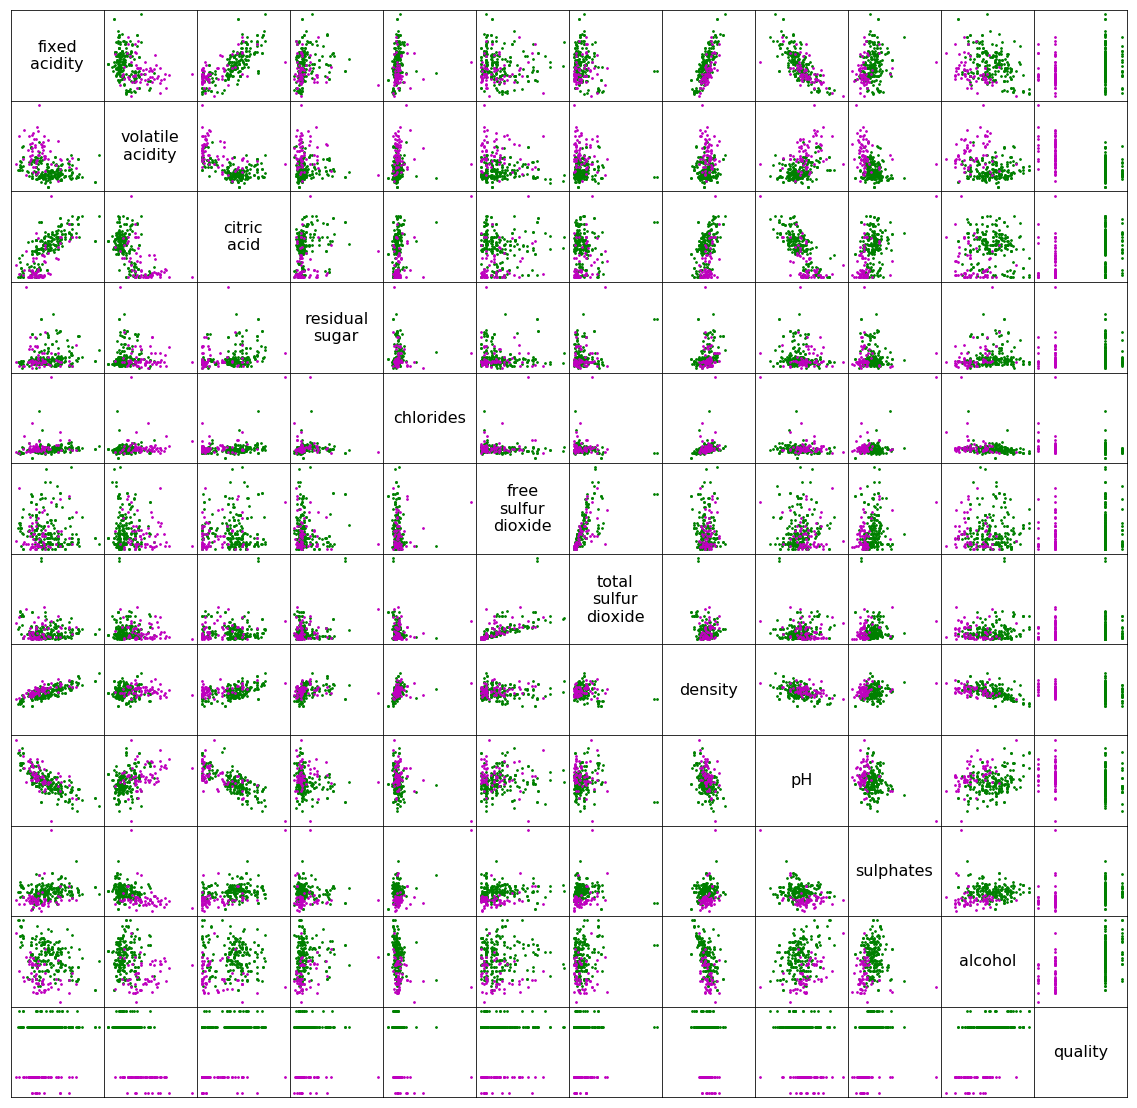

In [113]:
plot_scatter_matrix(red_wine_df, 6, 5)

#### b) Which factors do you think will be most useful for distinguishing high vs low quality wines

At a first glance I see that sulphates and alcohol have a clearer division when it comes to quality.
We can see in the figure that in most cases a higher alcohol quantity and a higher level of sulphates results
in a beter quality wine. This is the case when comparing high quality wines (8 or higher) vs low quality wines
(3 or lower)

### V.2 Learning to perceptron

#### a) & b) Perceptron implementation and training

In [140]:
def heaviside_step_fn(nb):
    if (nb < 0):
        return (0)
    elif (nb >= 0):
        return (1)

def dot_prod(v1, v2):
    return (sum([x * y for x, y in zip(v1, v2)]))

def vec_add(v1, v2):
    return ([round(x + y, 2) for x, y in zip(v1, v2)])
    
def vec_sub(v1, v2):
    return ([round(x - y, 2) for x, y in zip(v1, v2)])

def vec_scale(v, scalar):
    return ([i * scalar for i in v])

def select_features_labels(wine_data, good_quality_nb, bad_quality_nb, features_list=["pH", "alcohol"]):
    tmp = wine_data[features_list + ["quality"]][(
        wine_data['quality'] > good_quality_nb) | (wine_data['quality'] < bad_quality_nb)]
    tmp['quality'].where(tmp['quality'] < bad_quality_nb, 1, inplace=True) # Replace good_quality_nb and above with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and bad quality and below with 0
    features = tmp[features_list]
    labels = tmp[['quality']]
    features = [list(features[item]) for item in features]
    labels = [list(labels[item]) for item in labels]
    labels = labels[0]
    return (features, labels) # returns a list of lists containing the values of each feature

def update_weights(w, x, y, l_rate):
    update = False
    if (heaviside_step_fn(dot_prod(w, x)) == 1 and y == 0):
        update = True
        w = vec_sub(w, vec_scale(x, l_rate)) # w = w - lr * x
    elif (heaviside_step_fn(dot_prod(w, x)) == 0 and y == 1):
        update = True
        w = vec_add(w, vec_scale(x, l_rate)) # w = w + lr * x
    return (w, update)
    
def perceptron_trainer(wine_data, l_rate, epochs):
    features, labels = select_features_labels(wine_data, 7, 4)
    train_until_convergence = False
    epoch_count = 0
    info = []
    if (epochs == 0):
        train_until_convergence = True # train until convergence if epochs is 0
        epochs = 1 # epoch_count < epochs so it enters the loop
    converged = False
    w = [0, 0, 0] # w[0] is the bias
    for i in range(3):
        w[i] = round(random.uniform(-1, 1), 2) # init random weights between -1 and 1
    while (not converged and epoch_count < epochs):
        converged = True
        errors_at_epoch = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            w, update = update_weights(w, x, y, l_rate)
            if (update == True): # if there was no update in the whole dataset that means our model has converged
                converged = False
                errors_at_epoch += 1
        info.append((epoch_count, errors_at_epoch, w))
        epoch_count += 1
        if (train_until_convergence == True):
            epochs = epoch_count + 1 # we don't want to stop training until convergence
    return (info)

In [124]:
random.seed(1998)
performance = perceptron_trainer(red_wine_df, l_rate=0.98, epochs=0)

#### c) Plot perceptron performance

In [125]:
def plot_perceptron_performance(wine_data, performance, good_threshold, bad_threshold, feature_list=["pH", "alcohol"], epoch=-1):
    fig, axvec = plt.subplots(1, 2, figsize=(15, 5))
    if (epoch >= 0):
        performance = performance[: epoch + 1]
    else:
        epoch = performance[-1][0]
    df = pd.DataFrame(performance)
    
    plt.sca(axvec[0])
    plt.plot(df[0], df[1])
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Error as a function of epoch')
    
    plt.sca(axvec[1])
    good = plt.scatter(wine_data[feature_list[0]][wine_data['quality'] > good_threshold],
                wine_data[feature_list[1]][wine_data['quality'] > good_threshold], s=15, c='g')
    bad = plt.scatter(wine_data[feature_list[0]][wine_data['quality'] < bad_threshold],
                wine_data[feature_list[1]][wine_data['quality'] < bad_threshold], s=15, c='m')
    plt.legend((good, bad), ('good wines (> {} score)'.format(good_threshold),
                             'bad wines (< {} score)'.format(bad_threshold)), loc=(1.01, 0.88))
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.title('Decision boundary on epoch {}'.format(epoch))
    x_list = [2.8, 3.8]
    w = performance[-1][2]
    #w[0] /= 250
    #w[1] /= 250
    #w[2] /= 250
    print(w)
    x_intercept = -w[0] / w[1]
    y_intercept = -w[0] / w[2]
    # m = (y2 - y1) / (x2 - x1)
    m = -y_intercept / x_intercept
    # y = mx + b
    y = [0, 0]
    y[0] = m * x_list[0] + w[0]
    y[1] = m * x_list[1] + w[0]
    #y = (-1 * w[1] / w[2]) * x_list + (-1 * w[0] / w[2]) # this is just math. source: https://medium.com/@thomascountz/calculate-the-decision-boundary-of-a-single-perceptron-visualizing-linear-separability-c4d77099ef38
    #plt.plot(x_list, y)
    
    plt.show()

[478.42, -646.82, 161.1]


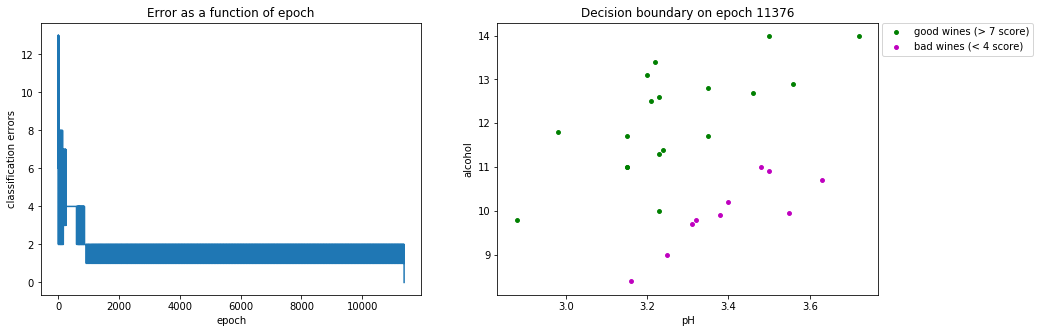

In [126]:
plot_perceptron_performance(red_wine_df, performance, 7, 4)

#### d) Feature scaling for faster training

In [ ]:
def normalize_data(wine_data):
    quality = wine_data["quality"]
    norm_wine_data = wine_data.drop(labels="quality", axis='columns')
    norm_wine_data = (norm_wine_data - norm_wine_data.mean()) / (norm_wine_data.max() - norm_wine_data.min())
    norm_wine_data["quality"] = quality
    return (norm_wine_data)

In [ ]:
random.seed(1998)
norm_red_wine_df = normalize_data(red_wine_df)
norm_perf = perceptron_trainer(norm_red_wine_df, l_rate=0.98, epochs=0)
plot_perceptron_performance(norm_red_wine_df, norm_perf, 7, 4)

### V.3 My fair ADALINE

#### a)&b)&c) Implement an ADALINE with gradient descent and a training function

In [5]:
class Adaline:
    def __init__(self):
        self.weights = [0, 0, 0]
        for i in range(3):
            self.weights[i] = round(random.uniform(-1, 1), 2) # w[0] is the bias
    def test(self, features, labels):
        error_count = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            if (dot_prod(self.weights, x) >= 0.5):
                output = 1
            else:
                output = 0
            if (y != output):
                error_count += 1
        return (error_count)
    def next_batch(self, features, labels, batch_size):
        for i in range(0, len(labels), batch_size):
            yield features[0][i:i + batch_size], features[1][i:i + batch_size], labels[i:i + batch_size]
    def batch_processing(self, features, labels, l_rate, batch_size):
        generator = self.next_batch(features, labels, batch_size)
        for batch_x1, batch_x2, batch_y in generator:
            batch_error = 0
            batch_gradient = [0, 0, 0]
            for x1, x2, y in zip(batch_x1, batch_x2, batch_y):
                x = [1, x1, x2]
                error = y - dot_prod(self.weights, x)
                gradient = vec_scale(v=x, scalar=2 * l_rate * error)
                batch_error += error
                batch_gradient = vec_add(batch_gradient, gradient)
            batch_error /= len(batch_x1)
            self.weights = vec_add(self.weights, batch_gradient)
    def train(self, wine_data, l_rate, batch_size=1, epochs=0, good_nb=6, bad_nb=5):
        features, labels = select_features_labels(wine_data, good_nb, bad_nb)
        train_until_convergence = False
        epoch_count = 0
        info = []
        if (epochs == 0):
            train_until_convergence = True # train until convergence if epochs is 0
            epochs = 1 # epoch_count < epochs so it enters the loop
        converged = False
        errors_at_prev_epoch = self.test(features, labels)
        count = 0
        info.append((epoch_count, errors_at_prev_epoch, self.weights))
        while (not converged and epoch_count < epochs):
            converged = True
            self.batch_processing(features, labels, l_rate, batch_size)
            errors_at_epoch = self.test(features, labels)
            if (errors_at_epoch > 0):
                if (errors_at_epoch >= errors_at_prev_epoch):
                    count += 1
                else:
                    count = 0
                if (count < 1000):
                    converged = False
            errors_at_prev_epoch = errors_at_epoch
            epoch_count += 1
            info.append((epoch_count, errors_at_epoch, self.weights))
            if (train_until_convergence == True):
                epochs = epoch_count + 1
        return (info)

#### d) Finding good hyperparameters for my ADALINE

In [ ]:
random.seed(1998)
good_threshold = 7
bad_threshold = 4
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.3, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.3, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.03, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.0003, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

In [ ]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df,
                        l_rate=0.0002,
                        batch_size=32,
                        epochs=0,
                        good_nb=good_threshold,
                        bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

### V.4 Advanced wine sampling and resampling

#### a) Holdout method to partition data in training and validation

In [ ]:
def partition_data(wine_data, validation_split):
    wine_data = wine_data.sample(frac=1).reset_index(drop=True) # shuffle data
    size = len(wine_data)
    validation_size = round(size * validation_split)
    training_size = size - validation_size
    return (wine_data.head(training_size), wine_data.tail(validation_size))

#### b) k-fold cross-validation dataset

In [ ]:
pd.set_option('display.max_rows', 2000)
def k_fold_validation(wine_data, k, shuffle=True):
    if (shuffle == True):
        wine_data = wine_data.sample(frac=1).reset_index(drop=True)
    k_size = round(len(wine_data) / k)
    k_folds = []
    for i in range(0, len(wine_data), k_size):
        k_folds.append(wine_data[i:i + k_size])
    k_tuples = []
    for i in range(k):
        training = pd.DataFrame()
        for j in range(k):
            if (i != j):
                training = pd.concat((training, k_folds[j]))
        k_tuples.append((training, k_folds[i]))
    return (k_tuples)

#### c) Effects on changing learning rate and epochs: k-fold cross-validation

In [ ]:
def adaline_k_fold_validation(wine_data, l_rate, k, shuffle=True,
                              batch_size=1, epochs=0, good_nb=6, bad_nb=5):
    if (epochs == 0):
        return(print("epochs can't be 0"))
    tmp = wine_data[['pH', 'alcohol', 'quality']][(
        wine_data['quality'] > good_nb) | (wine_data['quality'] < bad_nb)]
    tmp['quality'].where(tmp['quality'] < bad_nb, 1, inplace=True) # Replace above good_quality_nb with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and below bad_quality_nb 0
    k_folds = k_fold_validation(tmp, k, shuffle=shuffle)
    my_adaline = Adaline()
    
    errors = 0
    val_errors = 0
    for fold in k_folds:
        features, labels = select_features_labels(fold[0], good_nb, bad_nb)
        val_features, val_labels = select_features_labels(fold[1], good_nb, bad_nb)
        e = my_adaline.test(features, labels)
        val_e = my_adaline.test(val_features, val_labels)
        errors += e
        val_errors += val_e
    errors /= len(k_folds)
    val_errors /= len(k_folds)
    print("epoch 0: average training     errors: {:<4}/{:<4} => {:<2}%".format(errors, len(labels), round(errors / len(labels) * 100, 2)))
    print("         average validation   errors: {:<4}/{:<4} => {:<2}%".format(val_errors, len(val_labels), round(val_errors / len(val_labels) * 100, 2)))
    print("weights learned", my_adaline.weights)
    print()
    
    for epoch in range(epochs):
        errors = 0
        val_errors = 0
        for fold in k_folds:
            features, labels = select_features_labels(fold[0], good_nb, bad_nb)
            val_features, val_labels = select_features_labels(fold[1], good_nb, bad_nb)
            my_adaline.train(fold[0], l_rate=l_rate, batch_size=batch_size,
                             epochs=1, good_nb=good_nb, bad_nb=bad_nb)
            e = my_adaline.test(features, labels)
            val_e = my_adaline.test(val_features, val_labels)
            errors += e
            val_errors += val_e
        errors /= len(k_folds)
        val_errors /= len(k_folds)
        print("epoch {}: average training     errors: {:<4}/{:<4} => {:<2}%".format(epoch + 1, errors, len(labels), round(errors / len(labels) * 100, 2)))
        print("         average validation   errors: {:<4}/{:<4} => {:<2}%".format(val_errors, len(val_labels), round(val_errors / len(val_labels) * 100, 2)))
        print("weights learned", my_adaline.weights)
        print()

In [ ]:
random.seed(123)
adaline_k_fold_validation(red_wine_df, l_rate=0.003, k=10, epochs=3, shuffle=False)

In [ ]:
random.seed(123)
adaline_k_fold_validation(red_wine_df, l_rate=0.003, k=10, epochs=10, shuffle=False)

In [ ]:
random.seed(123)
adaline_k_fold_validation(red_wine_df, l_rate=0.00003, k=10, epochs=10, shuffle=False)

### V.5 Adventures in the Nth dimension

In [92]:
def select_features_labels_2(wine_data, feature_list, good_quality_nb, bad_quality_nb):
    tmp = wine_data[feature_list + ['quality']][(
        wine_data['quality'] > good_quality_nb) | (wine_data['quality'] < bad_quality_nb)]
    tmp['quality'].where(tmp['quality'] < bad_quality_nb, 1, inplace=True) # Replace good_quality_nb and above with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and bad quality and below with 0
    features = tmp[feature_list]
    labels = tmp[['quality']]
    features = [list(features[item]) for item in features]
    labels = [list(labels[item]) for item in labels]
    labels = labels[0]
    return (features, labels) # returns a list of lists containing the values of each feature

class Adaline_2:
    def __init__(self, input_size):
        self.weights = [0] * (input_size + 1)
        for i in range(input_size + 1):
            self.weights[i] = round(random.uniform(-1, 1), 2) # w[0] is the bias
    def test(self, features, labels):
        error_count = 0
        for x1, x2, x3, y in zip(features[0], features[1], features[2], labels): # !!!!!!!!!!!!!!
        #for x1, x2, x3, x4, y in zip(features[0], features[1], features[2], features[3], labels): # !!!!!!!!!!!!!!
            x = [1, x1, x2, x3] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            if (dot_prod(self.weights, x) >= 0.5):
                output = 1
            else:
                output = 0
            if (y != output):
                error_count += 1
        return (error_count)
    def next_batch(self, features, labels, batch_size):
        for i in range(0, len(labels), batch_size):
            yield features[0][i:i + batch_size], features[1][i:i + batch_size], features[2][i:i + batch_size], labels[i:i + batch_size] # !!!!!!!!
            #yield features[0][i:i + batch_size], features[1][i:i + batch_size], features[2][i:i + batch_size], features[3][i:i + batch_size], labels[i:i + batch_size] # !!!!!!!!
    def batch_processing(self, features, labels, l_rate, batch_size):
        generator = self.next_batch(features, labels, batch_size)
        for batch_x1, batch_x2, batch_x3, batch_y in generator: # !!!!!!!!!!!!!!!!!!!!!!!!!!!
        #for batch_x1, batch_x2, batch_x3, batch_x4, batch_y in generator: # !!!!!!!!!!!!!!!!!!!!!!!!!!!
            batch_error = 0
            batch_gradient = [0, 0, 0, 0] # !!!!!!!!!!!!!!!!!!!!!!!!!
            #batch_gradient = [0, 0, 0, 0, 0] # !!!!!!!!!!!!!!!!!!!!!!!!!
            for x1, x2, x3, y in zip(batch_x1, batch_x2, batch_x3, batch_y): # !!!!!!!!!!!!!!!!!!
            #for x1, x2, x3, x4, y in zip(batch_x1, batch_x2, batch_x3, batch_x4, batch_y): # !!!!!!!!!!!!!!!!!!
                x = [1, x1, x2, x3] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                #x = [1, x1, x2, x3, x4] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                error = y - dot_prod(self.weights, x)
                gradient = vec_scale(v=x, scalar=2 * l_rate * error)
                batch_error += error
                batch_gradient = vec_add(batch_gradient, gradient)
            batch_error /= len(batch_x1)
            self.weights = vec_add(self.weights, batch_gradient)
    def train(self, wine_data, feature_list, l_rate, batch_size=1, epochs=0, good_nb=6, bad_nb=5):
        features, labels = select_features_labels_2(wine_data, feature_list, good_nb, bad_nb)
        train_until_convergence = False
        epoch_count = 0
        info = []
        if (epochs == 0):
            train_until_convergence = True # train until convergence if epochs is 0
            epochs = 1 # epoch_count < epochs so it enters the loop
        converged = False
        errors_at_prev_epoch = self.test(features, labels)
        count = 0
        print("epoch {}: total errors: {:<4}/{:<4} => {:<2}%".format(epoch_count, errors_at_prev_epoch, len(labels), round(errors_at_prev_epoch / len(labels) * 100, 2)))
        print("weights learned", my_adaline.weights)
        info.append((epoch_count, errors_at_prev_epoch, self.weights))
        while (not converged and epoch_count < epochs):
            converged = True
            self.batch_processing(features, labels, l_rate, batch_size)
            errors_at_epoch = self.test(features, labels)
            if (errors_at_epoch > 0):
                if (errors_at_epoch >= errors_at_prev_epoch):
                    count += 1
                else:
                    count = 0
                if (count < 1000):
                    converged = False
            errors_at_prev_epoch = errors_at_epoch
            epoch_count += 1
            print("epoch {}: total errors: {:<4}/{:<4} => {:<2}%".format(epoch_count, errors_at_epoch, len(labels), round(errors_at_epoch / len(labels) * 100, 2)))
            print("weights learned", my_adaline.weights)
            info.append((epoch_count, errors_at_epoch, self.weights))
            if (train_until_convergence == True):
                epochs = epoch_count + 1
        return (info)

In [93]:
random.seed(123)
feature_list = ["pH", "alcohol", "sulphates"]
my_adaline = Adaline_2(input_size=3)
perf = my_adaline.train(red_wine_df, feature_list, l_rate=0.0001, batch_size=32, epochs=10)

epoch 0: total errors: 217 /280  => 77.5%
weights learned [-0.9, -0.83, -0.19, -0.78]
epoch 1: total errors: 59  /280  => 21.07%
weights learned [-0.9, -0.78, 0.49, -0.78]
epoch 2: total errors: 58  /280  => 20.71%
weights learned [-0.9, -0.78, 0.48, -0.78]
epoch 3: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 4: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 5: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 6: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 7: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 8: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 9: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]
epoch 10: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78]


In [91]:
# change code before running
random.seed(123)
feature_list = ["pH", "alcohol", "sulphates", "chlorides"]
my_adaline = Adaline_2(input_size=4)
perf = my_adaline.train(red_wine_df, feature_list, l_rate=0.0001, batch_size=32, epochs=10)

epoch 0: total errors: 217 /280  => 77.5%
weights learned [-0.9, -0.83, -0.19, -0.78, 0.8]
epoch 1: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 2: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 3: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 4: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 5: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 6: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 7: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 8: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 9: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8]
epoch 10: total errors: 54  /280  => 19.29%
weights learned [-0.9, -0.78, 0.47, -0.78, 0.8

#### b) Multiple dimensions decision boundary

In the case of 3 dimensions the decision boundary will be a plane that separates the data in a 3d space. In 4 or higher dimensions it will be a hyperplane and we can't visualize it.

### V.6 Marvin's rebuttal

#### a) Pan-Galactic Gargle Blaster dataset

In [96]:
galactic_df = pd.read_csv("resources/Pan Galactic Gargle Blaster.csv", sep=";")

In [98]:
galactic_df.head()

,wonderflonium,fallian marsh gas,quality
0,4.151636,5.350607,2
1,3.403125,4.787343,2
2,5.036224,4.609847,2
3,4.483534,4.332340,9
4,4.215979,5.220295,2


In [99]:
galactic_df.describe()

,wonderflonium,fallian marsh gas,quality
count,1000.000000,1000.000000,1000.00000
mean,4.242895,4.243644,5.06500
std,0.523069,0.521498,2.74815
min,2.898667,3.067114,1.00000
25%,3.968288,3.973995,3.00000
50%,4.244483,4.244885,5.00000
75%,4.502423,4.500133,8.00000
max,5.494472,5.393076,9.00000


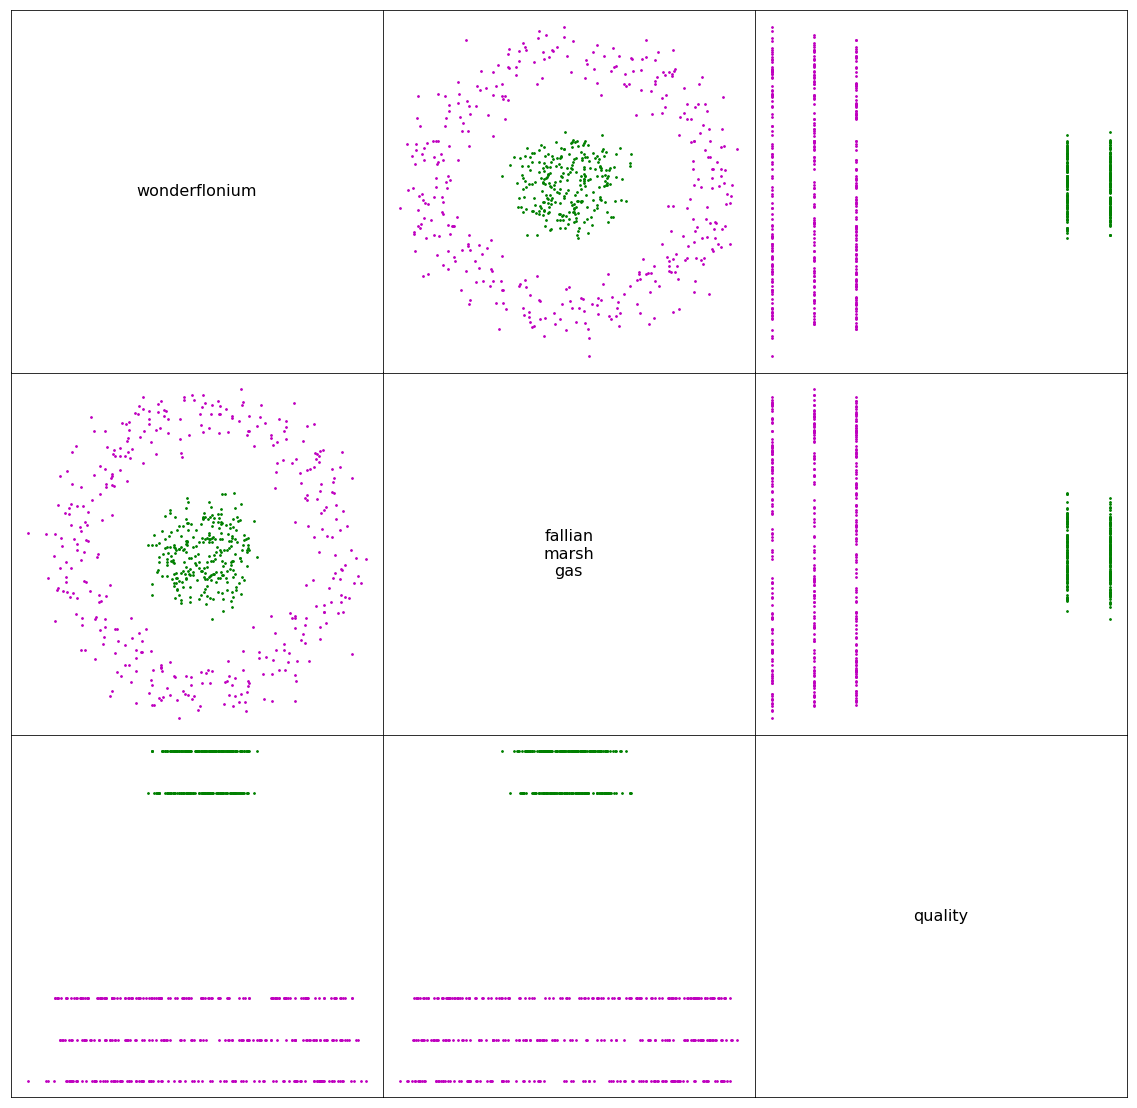

In [115]:
plot_scatter_matrix(galactic_df, 7, 4, rows=3, cols=3)

##### Just from looking at the data we can clearly see that it's impossible to classify it with a perceptron or Adaline because this algorithms are linear. There is no possible line that could separate this dataset. We need to use more complex nerworks to solve this.

In [138]:
class Adaline_galactic:
    def __init__(self):
        self.weights = [0, 0, 0]
        for i in range(3):
            self.weights[i] = round(random.uniform(-1, 1), 2) # w[0] is the bias
    def test(self, features, labels):
        error_count = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            if (dot_prod(self.weights, x) >= 0.5):
                output = 1
            else:
                output = 0
            if (y != output):
                error_count += 1
        return (error_count)
    def next_batch(self, features, labels, batch_size):
        for i in range(0, len(labels), batch_size):
            yield features[0][i:i + batch_size], features[1][i:i + batch_size], labels[i:i + batch_size]
    def batch_processing(self, features, labels, l_rate, batch_size):
        generator = self.next_batch(features, labels, batch_size)
        for batch_x1, batch_x2, batch_y in generator:
            batch_error = 0
            batch_gradient = [0, 0, 0]
            for x1, x2, y in zip(batch_x1, batch_x2, batch_y):
                x = [1, x1, x2]
                error = y - dot_prod(self.weights, x)
                gradient = vec_scale(v=x, scalar=2 * l_rate * error)
                batch_error += error
                batch_gradient = vec_add(batch_gradient, gradient)
            batch_error /= len(batch_x1)
            self.weights = vec_add(self.weights, batch_gradient)
    def train(self, data, l_rate, batch_size=1, epochs=0, good_nb=6, bad_nb=5):
        features, labels = select_features_labels(data, good_nb, bad_nb, features_list=["wonderflonium", "fallian marsh gas"])
        train_until_convergence = False
        epoch_count = 0
        info = []
        if (epochs == 0):
            train_until_convergence = True # train until convergence if epochs is 0
            epochs = 1 # epoch_count < epochs so it enters the loop
        converged = False
        errors_at_prev_epoch = self.test(features, labels)
        count = 0
        info.append((epoch_count, errors_at_prev_epoch, self.weights))
        while (not converged and epoch_count < epochs):
            converged = True
            self.batch_processing(features, labels, l_rate, batch_size)
            errors_at_epoch = self.test(features, labels)
            if (errors_at_epoch > 0):
                if (errors_at_epoch >= errors_at_prev_epoch):
                    count += 1
                else:
                    count = 0
                if (count < 1000):
                    converged = False
            errors_at_prev_epoch = errors_at_epoch
            epoch_count += 1
            info.append((epoch_count, errors_at_epoch, self.weights))
            if (train_until_convergence == True):
                epochs = epoch_count + 1
        return (info)

[-8.46, 1.03, 1.03]


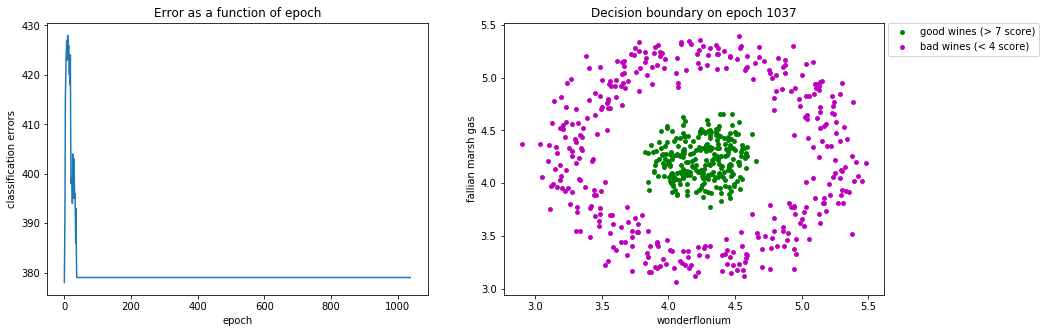

In [141]:
random.seed(123)
good_threshold = 7
bad_threshold = 4
my_adaline = Adaline_galactic()
perf = my_adaline.train(galactic_df, l_rate=0.003, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(galactic_df, perf, good_threshold, bad_threshold, feature_list=["wonderflonium", "fallian marsh gas"])